# TICKER TECHNICAL ANALYSIS

<img src="media/bull_bear.jpeg" alt="Alt Text" width="150"/>

Analsys of buy and sell signals for a given ticker price action for the specified date range. The buy and sell 
signals are based on common technical indicators, custom algorythms & compared against Machine Learning models.

In [2]:
""" Enter the stock ticker here """

ticker = 'SOFI'

### Imported Modules

In [3]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta
from IPython.display import display
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

### Date Range Ticker


In [4]:
"""
Get current date so we can always get the most recent date from yahoo finance.
date is formated at as YY-mm-dd.

"""


date = datetime.now() + timedelta(days=1)
end_date_fmt = date.strftime("%Y-%m-%d")
start_date = '2020-01-01'
istart_date = '2023-01-01'

### Using Yahoo API To Download Data

Sourcing data from Yahoo Finances into two variables df_daily and df_intra.

In [5]:
df_daily = yf.download(ticker, start = start_date, end = end_date_fmt, progress=False)
df_intra = yf.download(ticker, istart_date, end_date_fmt, progress=False, interval='60m')

In [6]:
df_daily.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,12.59,12.59,11.8,12.2,12.2,1371400


### Adding Hour, Day, Month Features

To be used for seasonality

In [37]:
# Changing Date colum to a date type so we can derive into day and month
df_daily['Day'] = df_daily.index.day_name()
df_daily['Month'] = df_daily.index.month_name()
df_intra['Day'] = df_intra.index.day_name()
df_intra['Month'] = df_intra.index.month_name()
df_intra['Hour'] = df_intra.index.strftime('%H:%M')
df_intra.head(3)

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Hour,Fastema,...,MidTerm_ema,macd12,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern,Trend
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-03 09:30:00,4.650,4.75,4.5201,4.5400,4.5400,7388473,Tuesday,January,09:30,4.540000,...,4.540000,4.540000,4.540000,0.000000,0.000000,0.000000,NaN,-1,-1,0
2023-01-03 10:30:00,4.545,4.59,4.5200,4.5462,4.5462,3615798,Tuesday,January,10:30,4.542067,...,4.540243,4.540954,4.540459,0.000495,0.000099,0.000396,100.000000,1,1,1
2023-01-03 11:30:00,4.545,4.55,4.4600,4.4800,4.4800,3454968,Tuesday,January,11:30,4.521378,...,4.537881,4.531576,4.535981,-0.004404,-0.000802,-0.003603,7.507292,-1,-1,-1


### Creating a Data Range Function To Filter Through The Dataframe For Exact Date Range Or Span

In [8]:
"""
The date_range function takes the dataset, a start/end date or span as agruments and returns a filter dataframe.

"""

def date_range(data, start=None, end=None, span=None):
    if start and end:
        return data[start:end]
    elif span is not None:
        cutoff_date = pd.Timestamp.now()-pd.Timedelta(days=span)
        return data[data.index >= cutoff_date]
    else:
        raise ValueError("Please provide either a date range (start='yyyy-mm-dd', end='yyyy-mm-dd') or span")



### Technical Indicator Functions

#### EMA

Three Exponential Moving Averages were used for this model (5, 7 & 50 Day EMA). The shorter term Exponential Moving Averages (5 & 7 Day EMA) captures the short term trends and momentum shifts. The longer term 50 Day EMA helps confirm the direction of long-term trends in a less volatile market. This also reduces noise when the market is in a sustainted downward trend or trending sideways.


In [9]:
""""
The EMA function calculates the Exponential Moving Average (ema) by finding the average between the fast and slow ema.
The Fastema and Slowema are added as columns to the database.

"""

def ema(dataset, fast, slow, mterm_ema):
   dataset['Fastema'] = dataset['Close'].ewm(span=fast, adjust=False).mean()
   dataset['Slowema'] = dataset['Close'].ewm(span=slow, adjust=False).mean()
   dataset['MidTerm_ema'] = dataset['Close'].ewm(span=mterm_ema, adjust=False).mean()

   return dataset

#### MACD Moving Average Convergence Divergence

The MACD line measures the difference between the 12 & 26 Day EMA. The higher the difference between the 12 & 26 indicates a more bullish momentium. Likewise, a negtive value would indicate the 12 is below the 26 showing a more bearish momentum. 

The Signal line is 9 Day EMA of the MACD line. When the MACD line crosses above the Signal Line indicates a more bullish momentum. 
A bullish trend is indicated when the MACD line crosses above the Signal Line and bearish when it crosses below the Signal Line. The strength of the trend can be seen in the differrnce between the MACD and Signal. Somtimes this measured as a histogram. 

In [10]:
"""
The macd1 function is calcuating the Moving Average Convergence Divergence (MACD) by finding the difference between 12 and 26 EMA.
Generate singals based on 9 day moving average.
Inserting a macd histogram that shows macd and signal crossing by finding the difference.
"""

def macd1(dataset):
    dataset['macd12'] =  dataset['Close'].ewm(span=12, adjust=False).mean()
    dataset['macd26'] = dataset['Close'].ewm(span=26, adjust=False).mean()
    dataset['macd'] = dataset['macd12'] - dataset['macd26']
    dataset['signal'] = dataset['macd'].ewm(span=9, adjust=False).mean()
    dataset['macd_hist'] = dataset['macd'] - dataset['signal']

    return dataset

#### RSI

In [11]:
"""
The RSI function calculates the Relative Strength Index (RSI).
The Median_RSI function calculates overbought_level and oversold_level to find the average.

"""

def rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    dataset['RSI'] = rsi

    median_rsi = np.median([overbought_level, oversold_level])
    dataset['Median_RSI'] = np.where(rsi > median_rsi, 1, -1)

    return(dataset)


#### Candle Pattern

Candle Pattern give a strong vivid visization shown by color and shapes that allows analyst to gauge at momentum and trend patterns that occur in the market.

In [12]:
'''
The Candle Pattern function is adding the column Candle_Pattern to the dataframe
Candle_Pattern is represented by 0 meaing no change, 1 meaning Close is > the Open, -1 Close < the Open indicating which candle to show.
'''

def candle_pattern(dataset):
    dataset['Candle_Pattern'] = 0
    dataset.loc[dataset['Close'] >= dataset['Open'], 'Candle_Pattern'] = 1
    dataset.loc[dataset['Close'] < dataset['Open'], 'Candle_Pattern'] = -1

    return dataset

### Creating Datasets To Combine Technical Indicators

In [13]:
# Added a variable called all_indicators that chains/links all technical indicators functions to run all at once.
all_indicators = candle_pattern(rsi(macd1(ema(df_daily,5, 7, 50)),70, 30))

In [14]:
all_indicators_intra = candle_pattern(rsi(macd1(ema(df_intra,5, 7, 50)),70, 30))

In [15]:
# Shows the first 5 rows of all_indicatos dataset.
all_indicators.head()

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Fastema,Slowema,MidTerm_ema,macd12,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern
Date,,,,,,,,,,,,,,,,,,,
2021-01-04,12.590000,12.59,11.800000,12.200000,12.200000,1371400,Monday,January,12.200000,12.200000,12.200000,12.200000,12.200000,0.000000,0.000000,0.000000,NaN,-1,-1
2021-01-05,12.150000,12.28,12.090000,12.150000,12.150000,1304000,Tuesday,January,12.183333,12.187500,12.198039,12.192307,12.196296,-0.003989,-0.000798,-0.003191,0.000000,-1,1
2021-01-06,12.150000,12.20,11.890000,12.120000,12.120000,1105700,Wednesday,January,12.162222,12.170625,12.194979,12.181183,12.190645,-0.009461,-0.002530,-0.006931,0.000000,-1,-1
2021-01-07,12.200000,22.00,12.050000,19.139999,19.139999,64877000,Thursday,January,14.488148,13.912968,12.467332,13.251770,12.705412,0.546359,0.107247,0.439111,99.102774,1,1
2021-01-08,21.459999,22.00,17.889999,18.740000,18.740000,35657000,Friday,January,15.905432,15.119726,12.713319,14.096113,13.152418,0.943695,0.274537,0.669158,93.040596,1,-1


In [16]:
all_indicators_intra.head()

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Hour,Fastema,Slowema,MidTerm_ema,macd12,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern
Datetime,,,,,,,,,,,,,,,,,,,,
2023-01-03 09:30:00,4.6500,4.75,4.5201,4.5400,4.5400,7388473,Tuesday,January,09:30,4.540000,4.540000,4.540000,4.540000,4.540000,0.000000,0.000000,0.000000,NaN,-1,-1
2023-01-03 10:30:00,4.5450,4.59,4.5200,4.5462,4.5462,3615798,Tuesday,January,10:30,4.542067,4.541550,4.540243,4.540954,4.540459,0.000495,0.000099,0.000396,100.000000,1,1
2023-01-03 11:30:00,4.5450,4.55,4.4600,4.4800,4.4800,3454968,Tuesday,January,11:30,4.521378,4.526162,4.537881,4.531576,4.535981,-0.004404,-0.000802,-0.003603,7.507292,-1,-1
2023-01-03 12:30:00,4.4799,4.49,4.4300,4.4796,4.4796,2755679,Tuesday,January,12:30,4.507452,4.514522,4.535595,4.523580,4.531804,-0.008224,-0.002286,-0.005938,7.459183,-1,-1
2023-01-03 13:30:00,4.4800,4.49,4.4500,4.4785,4.4785,3733647,Tuesday,January,13:30,4.497801,4.505516,4.533356,4.516645,4.527856,-0.011211,-0.004071,-0.007140,7.310548,-1,-1


### Algorithm To Determine Bullish And Bearish Trends

In [17]:
'''
Calculate Trend based on an algorithm using a mix of technical indicators.
'''

def technical_algorithm(dataset, bullish_algo_mix, bearish_algo_mix):
    # Bullish indicators
    rsi_bullish_check = dataset['Median_RSI'] == 1
    ema_bullish_cross = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Fastema'].shift(1) < dataset['Slowema'].shift(1))
    macd_bullish_cross = (dataset['macd'].shift(1) <= dataset['signal'].shift(1))
    macd_bullish_direction = dataset['macd_hist'] > dataset['macd_hist'].shift(1)
    candle_bullish = dataset['Close'] > dataset['Open']
    ema_bullish_cross2 = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Slowema'] > dataset['MidTerm_ema'])

    # Bearish indicators
    rsi_bearish_check = dataset['Median_RSI'] == -1
    ema_bearish_cross = (dataset['Fastema'] < dataset['Slowema']) & (dataset['Fastema'].shift(1) > dataset['Slowema'].shift(1))
    macd_bearish_direction = dataset['macd_hist'] <= dataset['macd_hist'].shift(1)
    candle_bearish = dataset['Close'] <= dataset['Open']
    ema_bearish_cross2 = dataset['Fastema'] < dataset['MidTerm_ema']


    # Dictionary to store my indicator combinations so we can easily set our algos against
    algo_mix = {
        'bullish1': macd_bullish_direction & candle_bullish,
        'bearish1': macd_bearish_direction & candle_bearish,
        'bullish2': macd_bullish_direction & candle_bullish & rsi_bullish_check,
        'bearish2': macd_bearish_direction & candle_bearish & rsi_bearish_check,
        'bullish3': ema_bullish_cross,
        'bearish3': ema_bearish_cross,
        'bullish4': ema_bullish_cross & macd_bullish_direction,
        'bearish4': ema_bearish_cross & macd_bearish_direction,
        'bullish5': ema_bullish_cross & macd_bullish_direction & candle_bullish & rsi_bullish_check,
        'bearish5': ema_bearish_cross & macd_bearish_direction & candle_bearish & rsi_bearish_check,
        'bullish6': ema_bullish_cross & rsi_bullish_check,
        'bearish6': ema_bearish_cross & rsi_bearish_check,
        'bullish7': ema_bullish_cross & macd_bullish_direction & candle_bullish,
        'bearish7': ema_bearish_cross & macd_bearish_direction & candle_bearish,
        'bullish8': ema_bullish_cross2,
        'bearish8': ema_bearish_cross2,
        'bullish9': macd_bullish_direction & candle_bullish & rsi_bullish_check & ema_bullish_cross2,
        'bearish9': macd_bearish_direction & candle_bearish & rsi_bearish_check & ema_bearish_cross2
    }

    # This sets our TREND.
    bullish_algo = algo_mix[bullish_algo_mix]
    bearish_algo = algo_mix[bearish_algo_mix]

    # Set default Trend to neutral where we don't get a bullish or bearish Trend
    dataset['Trend'] = 0  # Default value

    # Add Bullish and Bearish Trend Feature to Datasets using result of Algorythm
    dataset.loc[bullish_algo, 'Trend'] = 1
    dataset.loc[bearish_algo, 'Trend'] = -1

    return dataset

### Portfolio Performance Function for Daily

The portfolio_performance function is evaluating the performance of a trading strategy based on a dataset and a target feature that indicates buying or selling signals. 



In [18]:
def portfolio_performance(dataset, target_feature):
    # Get the first row where the trend is bullish.

    # transaction_daily database is copied and then adding the Bull_Bear column into databse.
    dataset = dataset.copy()
    dataset['Bull_Bear'] = ''

    # Check if there any bullish rows before access the first one
    bullish_rows = dataset[dataset[target_feature] == 1]
    if bullish_rows.empty:
        raise ValueError("No bullish rows found so cannot calculate initial investment")

    first_bullish_row = dataset[dataset[target_feature] == 1].iloc[0]
    initial_investment = first_bullish_row['Close']

    # cash = 0: Sets the initial cash balance to zero
    # Adds a "Cash" column to transaction_daily.
    cash = 0
    dataset['Cash'] = 0

    previous_trend = False

    # This code iterates over each row in transaction_daily to simulate buy and sell actions based on the target_feature signals.
    # This approach updates the cash balance and records buy/sell signals, switching trends only when new signals appear.
    for index, row in dataset.iterrows():
        if row[target_feature] == 1 and previous_trend == False:
            dataset.loc[index, "Bull_Bear"] = 'buy'
            cash -= row['Close']
            dataset.loc[index, 'Cash'] = cash
            previous_trend = True
        elif row[target_feature] == -1 and previous_trend == True:
            dataset.loc[index, "Bull_Bear"] = 'sell'
            cash += row['Close']
            dataset.loc[index, 'Cash'] = cash
            previous_trend = False
        else:
            pass

    # After loop check last row for a sell.
    last_row = dataset.iloc[-1]
    if previous_trend == True:
        dataset.loc[dataset.index[-1], "Bull_Bear"] = 'last_price'
        cash += last_row['Close']
        previous_trend = False


    return dataset, cash, initial_investment

## Analysis of Daily Bullish and Bearish Trends

### Daily Candle Stick Visualization Chart

This trading strategy uses the three day Exponential Moving Averages (EMA), 5,7, & 50 respectively. The 5 & 7 day EMA's (shorter term averages) are used as our short term indicators of momentum stock price trends. The 50 day EMA safeguards against longer term bearish condition, by not allowing a trade until the short term EMA's are above the 50 day EMA. Our bullish conidtion is when the 5 and 7 day EMA is above the 50 day EMA. Out of a mix of eight algorithms the EMA's were the highest yield. We also notice that this model did well by keeping us out of a trade when the stock price was trending sideways.




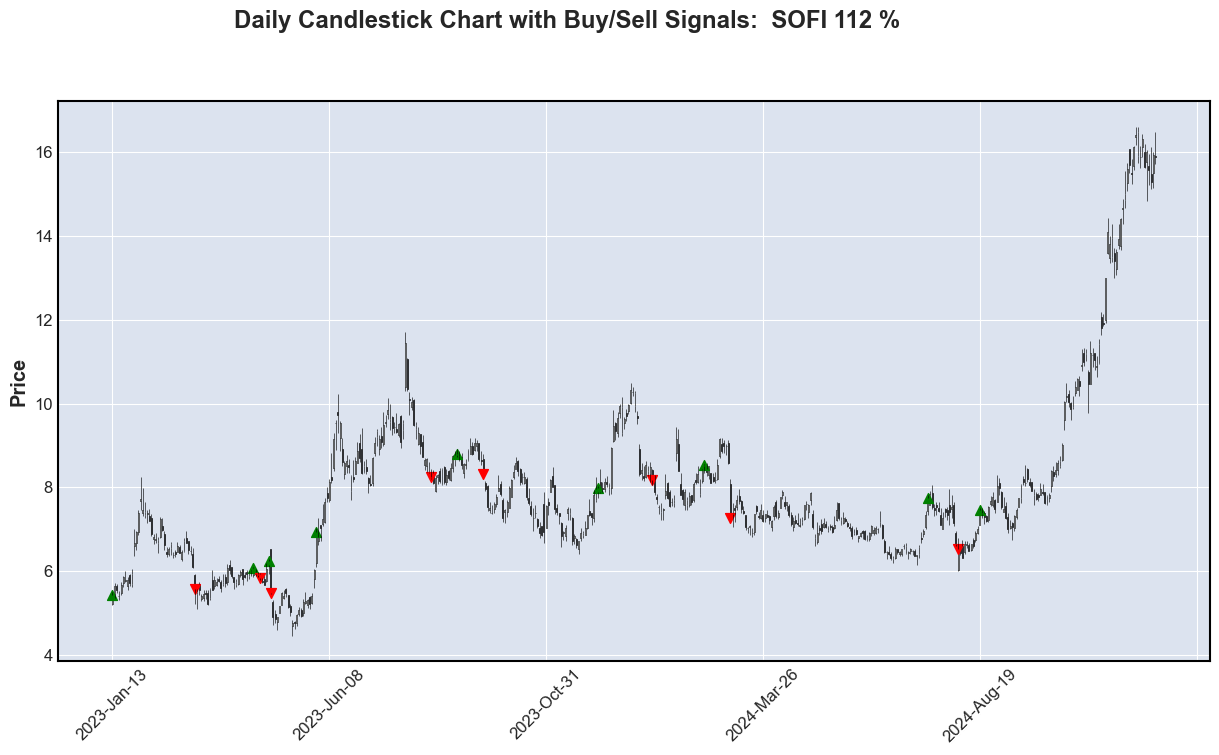

  Initial Investment:    5.440000057220459
       Ending Value:    6.13
Return On Investment:   112 %


,Close,Trend,Bull_Bear,Cash
Date,,,,
2023-01-13,5.44,1,buy,-5.44
2023-03-10,5.58,-1,sell,0.14
2023-04-19,6.08,1,buy,-5.94
2023-04-24,5.83,-1,sell,-0.11
2023-04-28,6.23,1,buy,-6.34
2023-05-01,5.47,-1,sell,-0.87
2023-05-31,6.94,1,buy,-7.81
2023-08-16,8.26,-1,sell,0.45
2023-09-01,8.79,1,buy,-8.34


In [19]:
'''
The code runs a technical alogrithm function that generates trading signals with database all_indicators, based on bullish/bearish conditions.
Filters these signals to a 60-day range using date_range.
Displays the first 50 transactions in transaction_daily.
ROI calculates the return on investment as a percentage.
mpf.plots puts the database into candle stick chart showing the buy (green) and sell (red) signal.
techn_algo = technical_algorithm(all_indicators, 'bullish9', 'bearish1')


'''

techn_algo = technical_algorithm(all_indicators, 'bullish8', 'bearish8')

filter_range = date_range(techn_algo, span=700)
transaction_daily, cash, initial_investment = portfolio_performance(filter_range, 'Trend')
transaction_daily.head(50)

roi = int((cash / initial_investment) * 100)


mpf.plot(
    transaction_daily,
    type='candle',
    title=f'Daily Candlestick Chart with Buy/Sell Signals:  {ticker} {roi} % ',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(transaction_daily['Bull_Bear'] == 'buy', transaction_daily['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='green'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(transaction_daily['Bull_Bear'] == 'sell', transaction_daily['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


print('  Initial Investment:   ',initial_investment)
print(f'       Ending Value:    {cash:.2f}')
print('Return On Investment:  ', roi, '%')

transaction_daily_flt = pd.DataFrame(transaction_daily, columns=['Close', 'Trend', 'Bull_Bear', 'Cash'])
transaction_daily_flt[transaction_daily_flt['Bull_Bear'] != '']

### Daily Seasonality 

The stacked bar chart shows percentage breakdown of stock performance by day of the week (up vs. down). <br>
The most bearish day Monday, which could be a good entry point for buying the stock. <br>
The most bullish day is Thursday. <br>

In [20]:
# create a pivote table and assign it to a new dataframe df_pvtDay
df_pvt_day= pd.pivot_table(filter_range, index='Day', columns='Candle_Pattern', aggfunc='size', fill_value=0)

# Display the first few rows of the normalized pivot table
df_pvt_day.head()

Candle_Pattern,-1,1
Day,,
Friday,43,55
Monday,37,52
Thursday,57,40
Tuesday,46,53
Wednesday,50,49


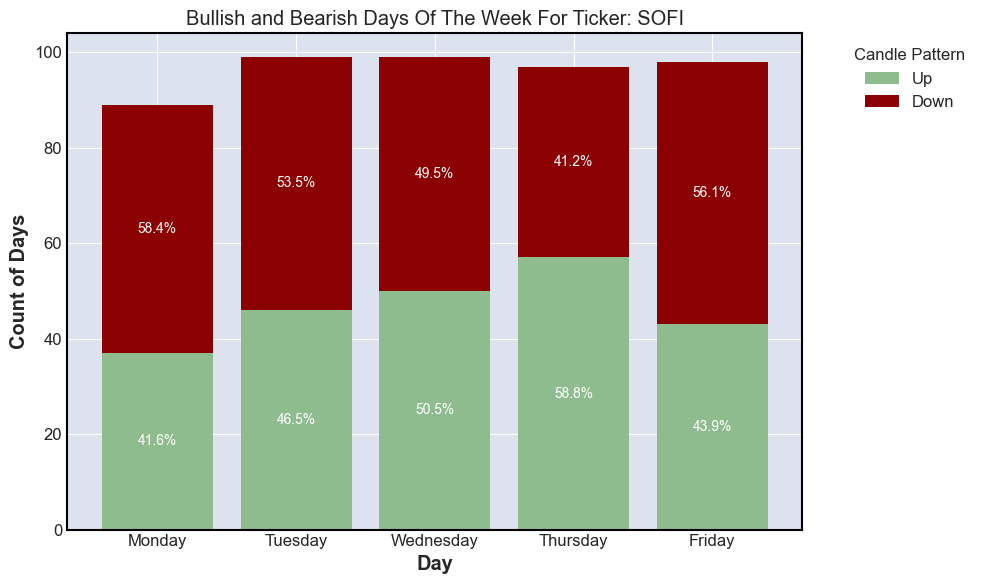

In [21]:

df_pvt_day_sort = pd.DataFrame(df_pvt_day, index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

# # Drop '% Up' column to focus on counts for 'Up' and 'Down'
# df_pvtDay_plot = df_pvt_day_sort.drop(columns='% Up')

# Calculate percentage for each category within each day (row-wise)
df_pvt_day_perc = df_pvt_day_sort.div(df_pvt_day_sort.sum(axis=1), axis=0) * 100

color_map = ['darkseagreen', 'darkred']


# Plotting the pivot table as a stacked bar chart
ax = df_pvt_day_sort.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, color=color_map)

# Adding percentage labels within each bar segment
for i, bar_group in enumerate(ax.containers):
    for j, bar in enumerate(bar_group):
        # Only label bars with a non-zero height
        height = bar.get_height()
        if height > 0:
            # Position the percentage label in the center of each bar segment
            x_position = bar.get_x() + bar.get_width() / 2
            y_position = bar.get_y() + height / 2

            # Retrieve the percentage value from df_pvtDay_percent
            percentage = df_pvt_day_perc.iloc[j, i]

            # Display the percentage inside each bar segment
            ax.text(
                x_position, y_position,  # Position in the center of the segment
                f'{percentage:.1f}%',  # Format to 1 decimal place
                ha='center', va='center', color='white', fontsize=10
            )

# Adding titles and labels
plt.title(f'Bullish and Bearish Days Of The Week For Ticker: {ticker}')
plt.xlabel('Day')
plt.ylabel('Count of Days')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability

ax.legend(['Up', 'Down'], title='Candle Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

### Intra Day Visualization And Performance

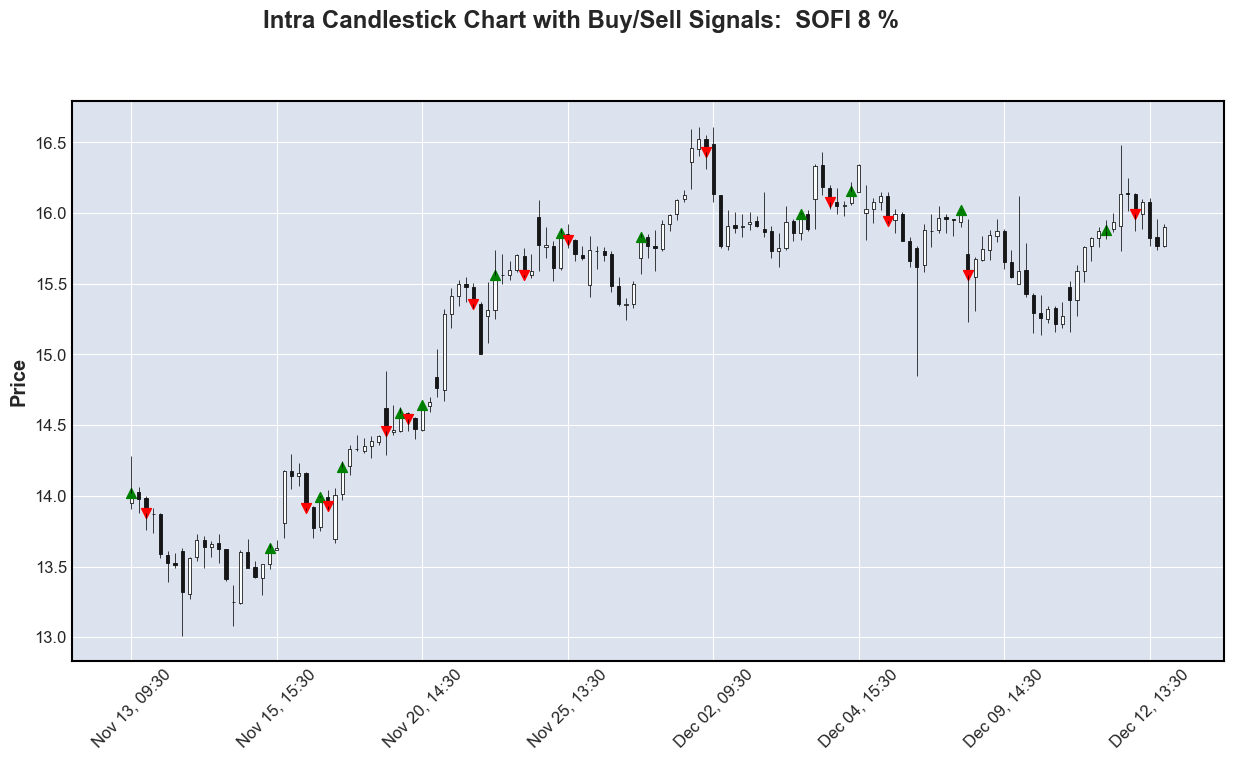

  Initial Investment:    14.02
       Net Gain/Loss:    1.08
Return On Investment:    8 %


,Close,Trend,Bull_Bear,Cash
Datetime,,,,
2024-11-13 09:30:00,14.020000,1,buy,-14.020000
2024-11-13 11:30:00,13.876900,-1,sell,-0.143101
2024-11-15 14:30:00,13.629800,1,buy,-13.772901
2024-11-18 12:30:00,13.915000,-1,sell,0.142099
2024-11-18 14:30:00,13.994200,1,buy,-13.852100
2024-11-18 15:30:00,13.930000,-1,sell,0.077900
2024-11-19 10:30:00,14.205000,1,buy,-14.127100
2024-11-20 09:30:00,14.460000,-1,sell,0.332900
2024-11-20 11:30:00,14.584300,1,buy,-14.251400


In [22]:

techn_algo = technical_algorithm(all_indicators_intra, 'bullish9', 'bearish1')
# filter_range = date_range(techn_algo, start='2024-10-01',end=end_date_fmt)
filter_range_intra = date_range(techn_algo, span=30)
all_indicators_intra, icash, iinitial_investment = portfolio_performance(filter_range_intra, 'Trend')
# all_indicators_intra.head(50)

iroi = ((icash / iinitial_investment) * 100)


mpf.plot(
    all_indicators_intra,
    type='candle',
    title=f'Intra Candlestick Chart with Buy/Sell Signals:  {ticker} {round(iroi)} % ',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(all_indicators_intra['Bull_Bear'] == 'buy', all_indicators_intra['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='green'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(all_indicators_intra['Bull_Bear'] == 'sell', all_indicators_intra['Close'], np.nan),
            type='scatter',
            markersize=50,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


print(f'  Initial Investment:    {iinitial_investment:.2f}')
print(f'       Net Gain/Loss:    {icash:.2f}')
print(f'Return On Investment:    {round(iroi)} %')

all_indicators_intra_trans = pd.DataFrame(all_indicators_intra, columns=['Close', 'Trend', 'Bull_Bear', 'Cash'])
all_indicators_intra_trans[all_indicators_intra_trans['Bull_Bear'] != '']

In [23]:
# transaction_daily fitlers throuhg only the Bull_Bear Column where they are empty.
# transaction_daily[transaction_daily['Bull_Bear'] != '']
all_indicators_intra[all_indicators_intra['Bull_Bear'] != '']



,Open,High,Low,Close,Adj Close,Volume,Day,Month,Hour,Fastema,...,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern,Trend,Bull_Bear,Cash
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-13 09:30:00,13.950000,14.280000,13.910000,14.020000,14.020000,14810594,Wednesday,November,09:30,13.878290,...,13.336851,0.433219,0.498333,-0.065115,69.541846,1,1,1,buy,-14.020000
2024-11-13 11:30:00,13.985000,14.000000,13.760000,13.876900,13.876900,5642387,Wednesday,November,11:30,13.900429,...,13.420967,0.392867,0.464367,-0.071500,57.737561,1,-1,-1,sell,-0.143101
2024-11-15 14:30:00,13.515000,13.660000,13.480000,13.629800,13.629800,4822493,Friday,November,14:30,13.535359,...,13.504134,0.039729,0.080661,-0.040933,54.875182,1,1,1,buy,-13.772901
2024-11-18 12:30:00,14.160000,14.170000,13.901000,13.915000,13.915000,4535455,Monday,November,12:30,13.960027,...,13.666508,0.146337,0.107792,0.038545,56.580601,1,-1,-1,sell,0.142099
2024-11-18 14:30:00,13.780000,14.000000,13.750000,13.994200,13.994200,3992768,Monday,November,14:30,13.929190,...,13.697880,0.137289,0.117577,0.019711,58.800504,1,1,1,buy,-13.852100
2024-11-18 15:30:00,13.995000,14.040000,13.905000,13.930000,13.930000,5664755,Monday,November,15:30,13.929460,...,13.715074,0.134684,0.120999,0.013685,55.333282,1,-1,-1,sell,0.077900
2024-11-19 10:30:00,14.010000,14.250000,13.970000,14.205000,14.205000,7256816,Tuesday,November,10:30,14.038093,...,13.771250,0.153370,0.130048,0.023322,66.265052,1,1,1,buy,-14.127100
2024-11-20 09:30:00,14.625000,14.885000,14.290000,14.460000,14.460000,15544299,Wednesday,November,09:30,14.378768,...,13.998848,0.222801,0.187396,0.035406,75.381648,1,-1,-1,sell,0.332900
2024-11-20 11:30:00,14.460000,14.630000,14.455000,14.584300,14.584300,3657763,Wednesday,November,11:30,14.466441,...,14.074187,0.234934,0.203034,0.031900,80.489397,1,1,1,buy,-14.251400


### Intra Day Seasonality

The stacked bar chart shows percentage breakdown of stock performance by hour of the day (up vs. down). <br>
The most bearish hour is starting at 9:30am, which could be a good entry point for buying the stock. <br>
The most bullish hour is 11:30am to 12:30pm. <br>



In [24]:
# create a pivote table and assign it to a new dataframe df_pvtDay
df_pvt_intra= pd.pivot_table(filter_range_intra, index='Hour', columns='Candle_Pattern', aggfunc='size', fill_value=0)

# Display the first few rows of the normalized pivot table
df_pvt_intra.head(20)

Candle_Pattern,-1,1
Hour,,
09:30,9,12
10:30,8,13
11:30,9,12
12:30,9,11
13:30,9,11
14:30,10,10
15:30,9,11


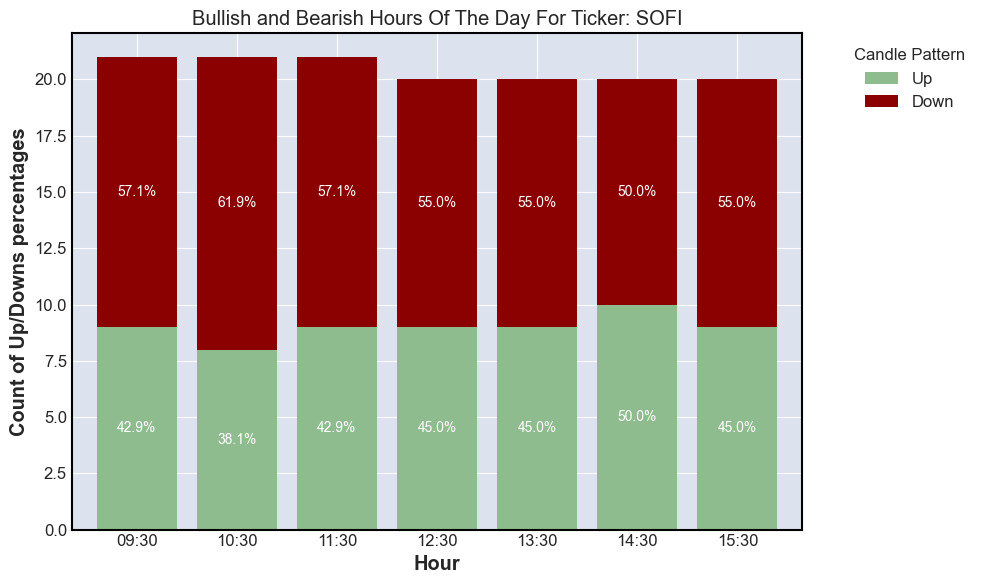

In [25]:
# Calculate percentage for each category within each day (row-wise)
df_pvt_intra_perc = df_pvt_intra.div(df_pvt_intra.sum(axis=1), axis=0) * 100

color_map = ['darkseagreen', 'darkred']


# Plotting the pivot table as a stacked bar chart
ax = df_pvt_intra.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, color=color_map)

# Adding percentage labels within each bar segment
for i, bar_group in enumerate(ax.containers):
    for j, bar in enumerate(bar_group):
        # Only label bars with a non-zero height
        height = bar.get_height()
        if height > 0:
            # Position the percentage label in the center of each bar segment
            x_position = bar.get_x() + bar.get_width() / 2
            y_position = bar.get_y() + height / 2

            # Retrieve the percentage value from df_pvtDay_percent
            percentage = df_pvt_intra_perc.iloc[j, i]

            # Display the percentage inside each bar segment
            ax.text(
                x_position, y_position,  # Position in the center of the segment
                f'{percentage:.1f}%',  # Format to 1 decimal place
                ha='center', va='center', color='white', fontsize=10
            )

# Adding titles and labels
plt.title(f'Bullish and Bearish Hours Of The Day For Ticker: {ticker}')
plt.xlabel('Hour')
plt.ylabel('Count of Up/Downs percentages')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability

ax.legend(['Up', 'Down'], title='Candle Pattern', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# AI Machine Learning Comparison

We will use Machine Learning to find patterns in our features to predict trends vs my own selection of technical algorithms.   

### Data Cleaning

In [26]:
# Check for nulls, blanks, nan
all_indicators.isnull().sum()
all_indicators_intra.isnull().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Day               0
Month             0
Hour              0
Fastema           0
Slowema           0
MidTerm_ema       0
macd12            0
macd26            0
macd              0
signal            0
macd_hist         0
RSI               0
Median_RSI        0
Candle_Pattern    0
Trend             0
Bull_Bear         0
Cash              0
dtype: int64

In [27]:
# Drop Nulls
all_indicators.dropna(inplace=True)
all_indicators_intra.dropna(inplace=True)

###  K-Nearest Neighbors Supervised Machine Learning Algorythm

The Predicted_Trend data is the K-Nearest Neighbors (KNN) Machine Learning algorythm prediction.  The KNN model is trained on the historical data, with the "Trend" feature as the target lable. The Trend feature is the actual trend direction to predict.  During training, the model learns specific feature patterns (the combinations of technical indicators) with different trends.

Making Predictions:
When you provide the model with new data (the test set), it predicts the trend direction based on the nearest neighbors in the feature space. This is stored in y_pred, which then gets assigned to Predicted_Trend.

Understanding Predicted_Trend: 
Each value in Predicted_Trend is the model's prediction of the trend direction, based on the patterns it learned during training. It’s essentially the model’s best guess of whether the trend is likely to be upward, downward, or follow any other trend category you specified.

Evaluating Performance: 
You can compare Predicted_Trend with the actual Trend in the test data to measure the model’s accuracy and understand how well it generalizes to unseen data.

Predicted_Trend is the KNN model’s forecast of future trends based on the features provided.

In [28]:
transaction_daily.head()

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Fastema,Slowema,...,macd26,macd,signal,macd_hist,RSI,Median_RSI,Candle_Pattern,Trend,Bull_Bear,Cash
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-13,5.225,5.49,5.190,5.44,5.44,32477100,Friday,January,5.198529,5.103250,...,4.817530,0.131894,0.017496,0.114399,80.298736,1,1,1,buy,-5.44
2023-01-17,5.450,5.72,5.360,5.64,5.64,37801400,Tuesday,January,5.345686,5.237438,...,4.878454,0.177213,0.049439,0.127774,83.968892,1,1,1,,0.00
2023-01-18,5.650,5.70,5.480,5.56,5.56,38396700,Wednesday,January,5.417124,5.318078,...,4.928939,0.204318,0.080415,0.123903,77.320833,1,-1,1,,0.00
2023-01-19,5.410,5.53,5.310,5.41,5.41,32006500,Thursday,January,5.414749,5.341059,...,4.964573,0.211260,0.106584,0.104676,66.013524,1,1,1,,0.00
2023-01-20,5.485,5.75,5.431,5.67,5.67,31135600,Friday,January,5.499833,5.423294,...,5.016827,0.235032,0.132273,0.102758,73.704402,1,1,1,,0.00


### Machine Learning Targeting Candle Pattern - Daily

In [29]:
df_knn = transaction_daily.copy()

df_knn = technical_algorithm(df_knn, 'bullish3', 'bearish3')

shifted_features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'Fastema',
    'Slowema', 'MidTerm_ema', 'macd', 'signal', 'macd_hist',
    'RSI', 'Median_RSI', 'Candle_Pattern', 'Trend', 'Trend', 'Trend']

nlag = 5

for ftrs in shifted_features:
    for lag in range(1, nlag+1):
        df_knn[f'{ftrs}_Lag{lag}'] = df_knn[ftrs].shift(lag)

df_knn['Target'] = df_knn['Candle_Pattern']
df_knn.dropna(inplace=True)
X = df_knn[[f'{ftrs}_Lag{lag}' for ftrs in shifted_features for lag in range(1, nlag+1)]]
y = df_knn['Target']

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Track predictions and see where the mistakes are
df_test_knn = df_knn.iloc[-len(X_test):].copy()
df_test_knn['Predicted_Candle'] = y_pred

# Visualize errors
mismatches = df_test_knn[df_test_knn['Predicted_Candle'] != df_test_knn['Candle_Pattern']]
print(f'Number of mismatches: {len(mismatches)}')




Accuracy: 48.96%
Number of mismatches: 49


In [30]:
df_test_knn[['Open','Close','Candle_Pattern', 'Predicted_Candle']].tail(10)

,Open,Close,Candle_Pattern,Predicted_Candle
Date,,,,
2024-11-29,16.360001,16.41,1,-1
2024-12-02,16.490000,15.91,-1,-1
2024-12-03,15.890000,15.88,-1,-1
2024-12-04,16.129999,16.32,1,-1
2024-12-05,16.010000,15.65,-1,-1
2024-12-06,15.770000,16.02,1,-1
2024-12-09,15.680000,15.57,-1,-1
2024-12-10,15.490000,15.29,-1,-1
2024-12-11,15.500000,15.94,1,-1


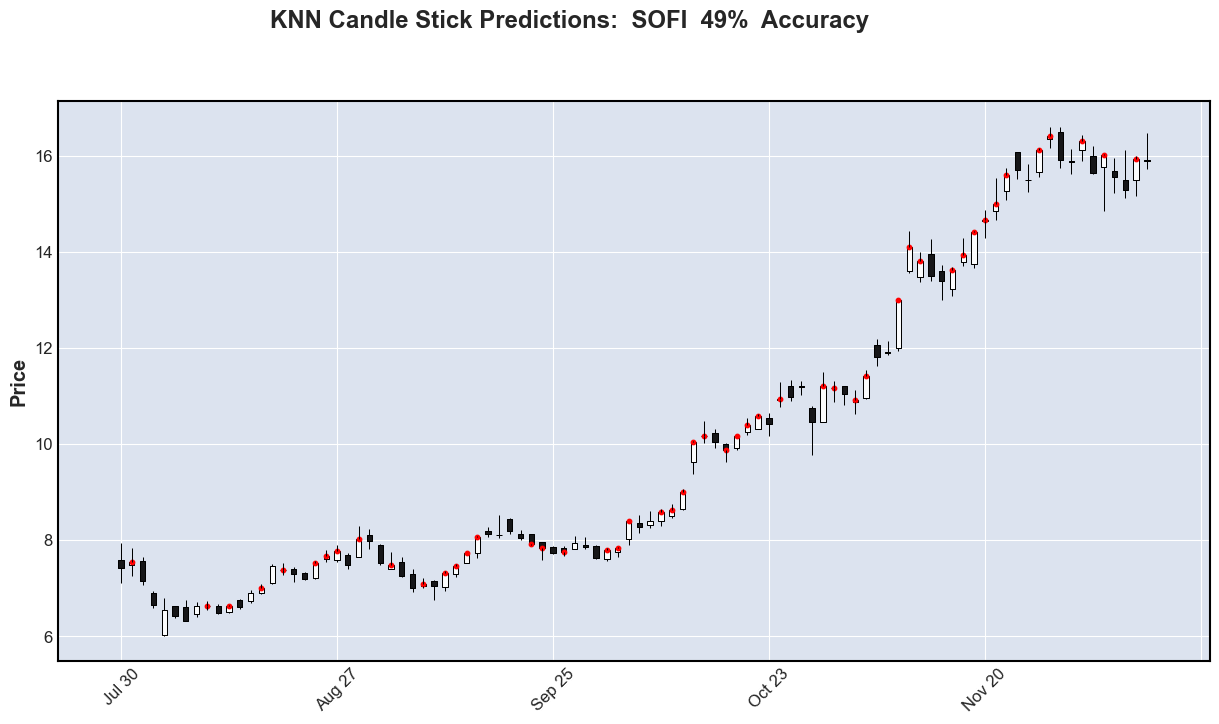

In [31]:
'''
 The code generates a candlestick chart using the mplfinance library (mpf.plot) to visualize stock price data and overlays a scatter plot highlighting mismatched candlestick predictions.
 Lets break it down step by step

'''



mpf.plot(
    df_test_knn,
    type='candle',
    title=f'KNN Candle Stick Predictions:  {ticker}  {round(accuracy*100)}%  Accuracy',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df_test_knn['Predicted_Candle'] != df_test_knn['Candle_Pattern'], df_test_knn['Close'], np.nan),
            type='scatter',
            markersize=10,  # Marker size
            marker='o',      # Downward triangle for mismatched candles
            color='red'      # Color for mismatched candles
        )
    ]
)

# Gradient Boosting

Accuracy: 54.43%


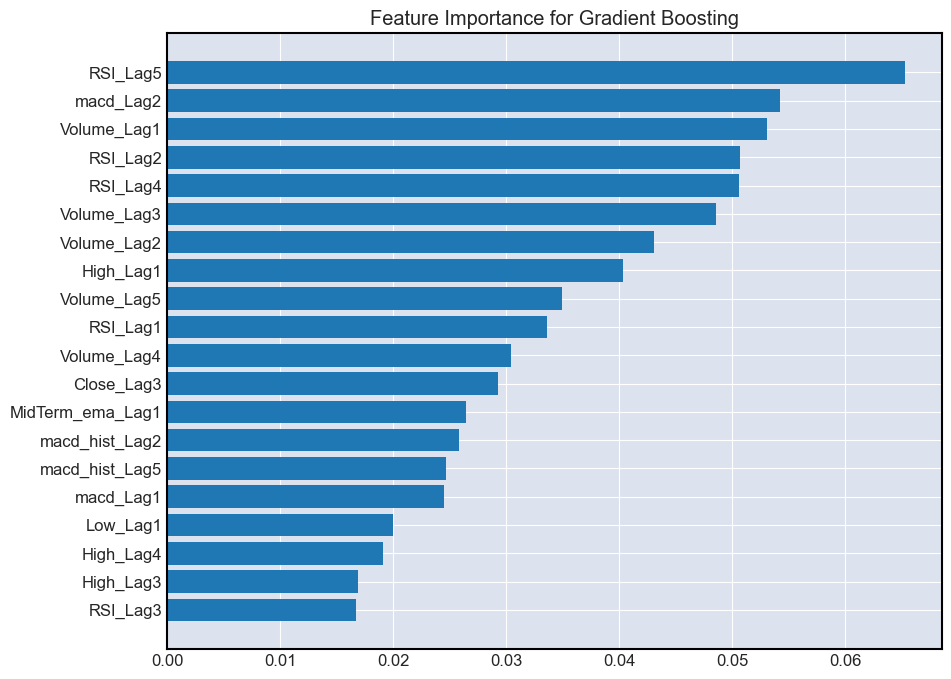

In [53]:
# Data Preparation
df_gboost = transaction_daily.copy()

# features list to shift
shifted_features = [
    'High', 'Low', 'Close', 'Volume', 'Fastema',
    'Slowema', 'MidTerm_ema', 'macd', 'signal', 'macd_hist',
    'RSI', 'Median_RSI', 'Candle_Pattern', 'Trend', 'Trend', 'Trend']

nlag = 5

for ftrs in shifted_features:
    for lag in range(1, nlag+1):
        df_gboost[f'{ftrs}_Lag{lag}'] = df_gboost[ftrs].shift(lag)

# Define the Target (Tomorrow's Candle Pattern)
df_gboost['Target'] = df_gboost['Candle_Pattern'].shift(-1)
df_gboost.dropna(inplace=True)

# Define Features (X) and Target (y)
X = df_gboost[[f'{feature}_Lag{lag}' for feature in shifted_features for lag in range(1, nlag + 1)]]
y = df_gboost['Target']

# Use Time Series Split for Training/Testing
tscv = TimeSeriesSplit(n_splits=5)
X_train, X_test, y_train, y_test = None, None, None, None

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Hyperparameter Tuning (Optional)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}


"""
# Uncomment to run the GridSearchCV (takes a while)
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)

# Instantiate the Gradient Boosting Model (can use GridSearchCV results)
gbm = GradientBoostingClassifier(**grid_search.best_params_)
Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=15) Copy previous values

"""

gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=15)

# Train the Model
gbm.fit(X_train, y_train)

# Make Predictions
predictions = gbm.predict(X_test)

# Evaluate the Model
accuracy_gb_rnd = round((accuracy_score(y_test, predictions) * 100), 2)
print(f'Accuracy: {accuracy_gb_rnd}%')

# # Confusion Matrix and Classification Report
# conf_matrix = confusion_matrix(y_test, predictions)
# # class_report = classification_report(y_test, predictions)

# print(f'\nConfusion Matrix:\n{conf_matrix}')
# print(f'\nClassification Report:\n{class_report}')

# Feature Importance Visualization
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20 most important features

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.title('Feature Importance for Gradient Boosting')
plt.show()

# Cross-Validation for Robust Accuracy
cv_scores = cross_val_score(gbm, X, y, cv=5, scoring='accuracy')


In [34]:
all_predictions = gbm.predict(X)
df_gboost.loc[X.index, 'Predicted_Candle'] = all_predictions


## Visualization

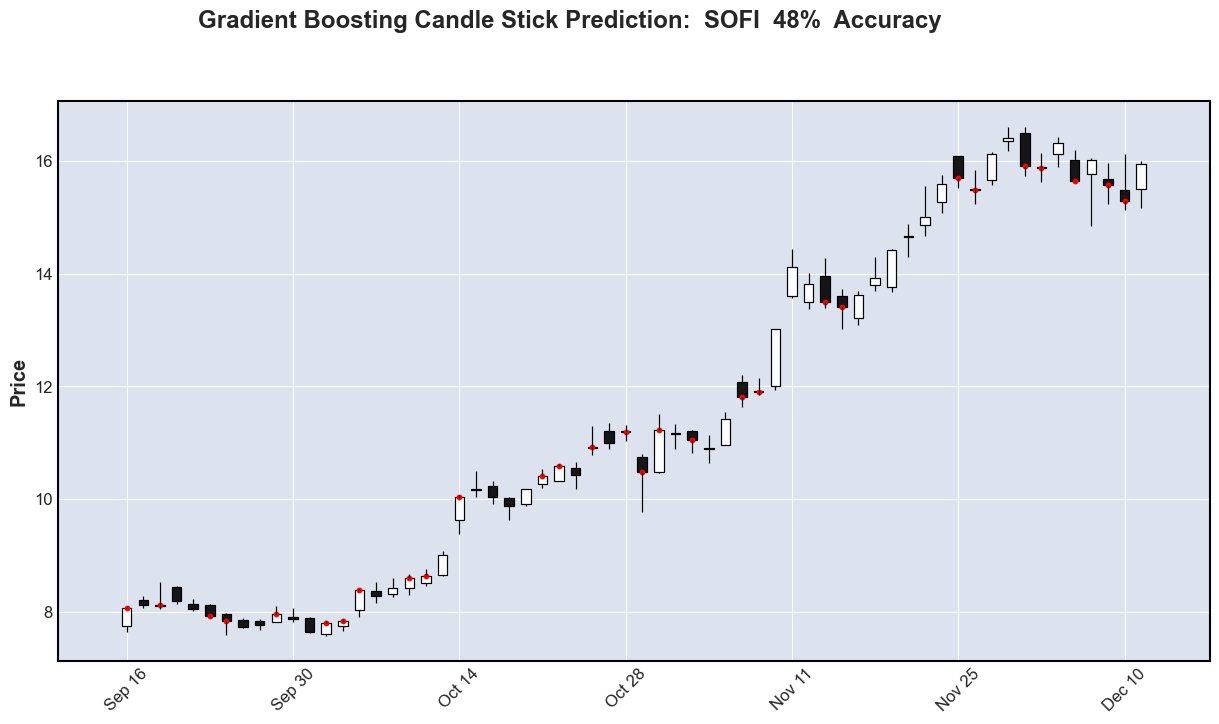

In [38]:
# df_boost_range = date_range(df_gboost, start='2024-11-26', end='2024-12-11')
df_boost_range = date_range(df_gboost, span=90)


mpf.plot(
    df_boost_range,
    type='candle',
    title=f'Gradient Boosting Candle Stick Prediction:  {ticker}  {round(accuracy_gb_rnd)}%  Accuracy',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df_boost_range['Predicted_Candle'] != df_boost_range['Candle_Pattern'], df_boost_range['Close'], np.nan),
            type='scatter',
            markersize=10,  # Marker size
            marker='o',      # Downward triangle for mismatched candles
            color='red'      # Color for mismatched candles
        )
    ]
)

In [36]:
# Predict tomorrow's trend based on the latest available day's data
# Get the latest row of data
latest_data = df_gboost.iloc[-1:].copy()

# Create lagged features for the latest data point
for feature in shifted_features:
    for lag in range(1, nlag + 1):
        latest_data[f'{feature}_Lag{lag}'] = df_gboost[feature].iloc[-lag-1]

# Select only the features used in training
X_tomorrow = latest_data[[f'{feature}_Lag{lag}' for feature in shifted_features for lag in range(1, nlag + 1)]]

# Make the prediction
tomorrow_prediction = gbm.predict(X_tomorrow)

print(f"Tomorrow's Prediction For {ticker}:", tomorrow_prediction[0])

Tomorrow's Prediction For SOFI: 1.0
